In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Image

# To plot trees in forest via graphviz
from sklearn.tree import export_graphviz
import graphviz

try:
    from latexify import latexify, format_axes
    latexify(columns=2)
except:
    pass

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Load IRIS dataset from Seaborn
iris = sns.load_dataset('iris')
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [3]:
# classes
iris.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

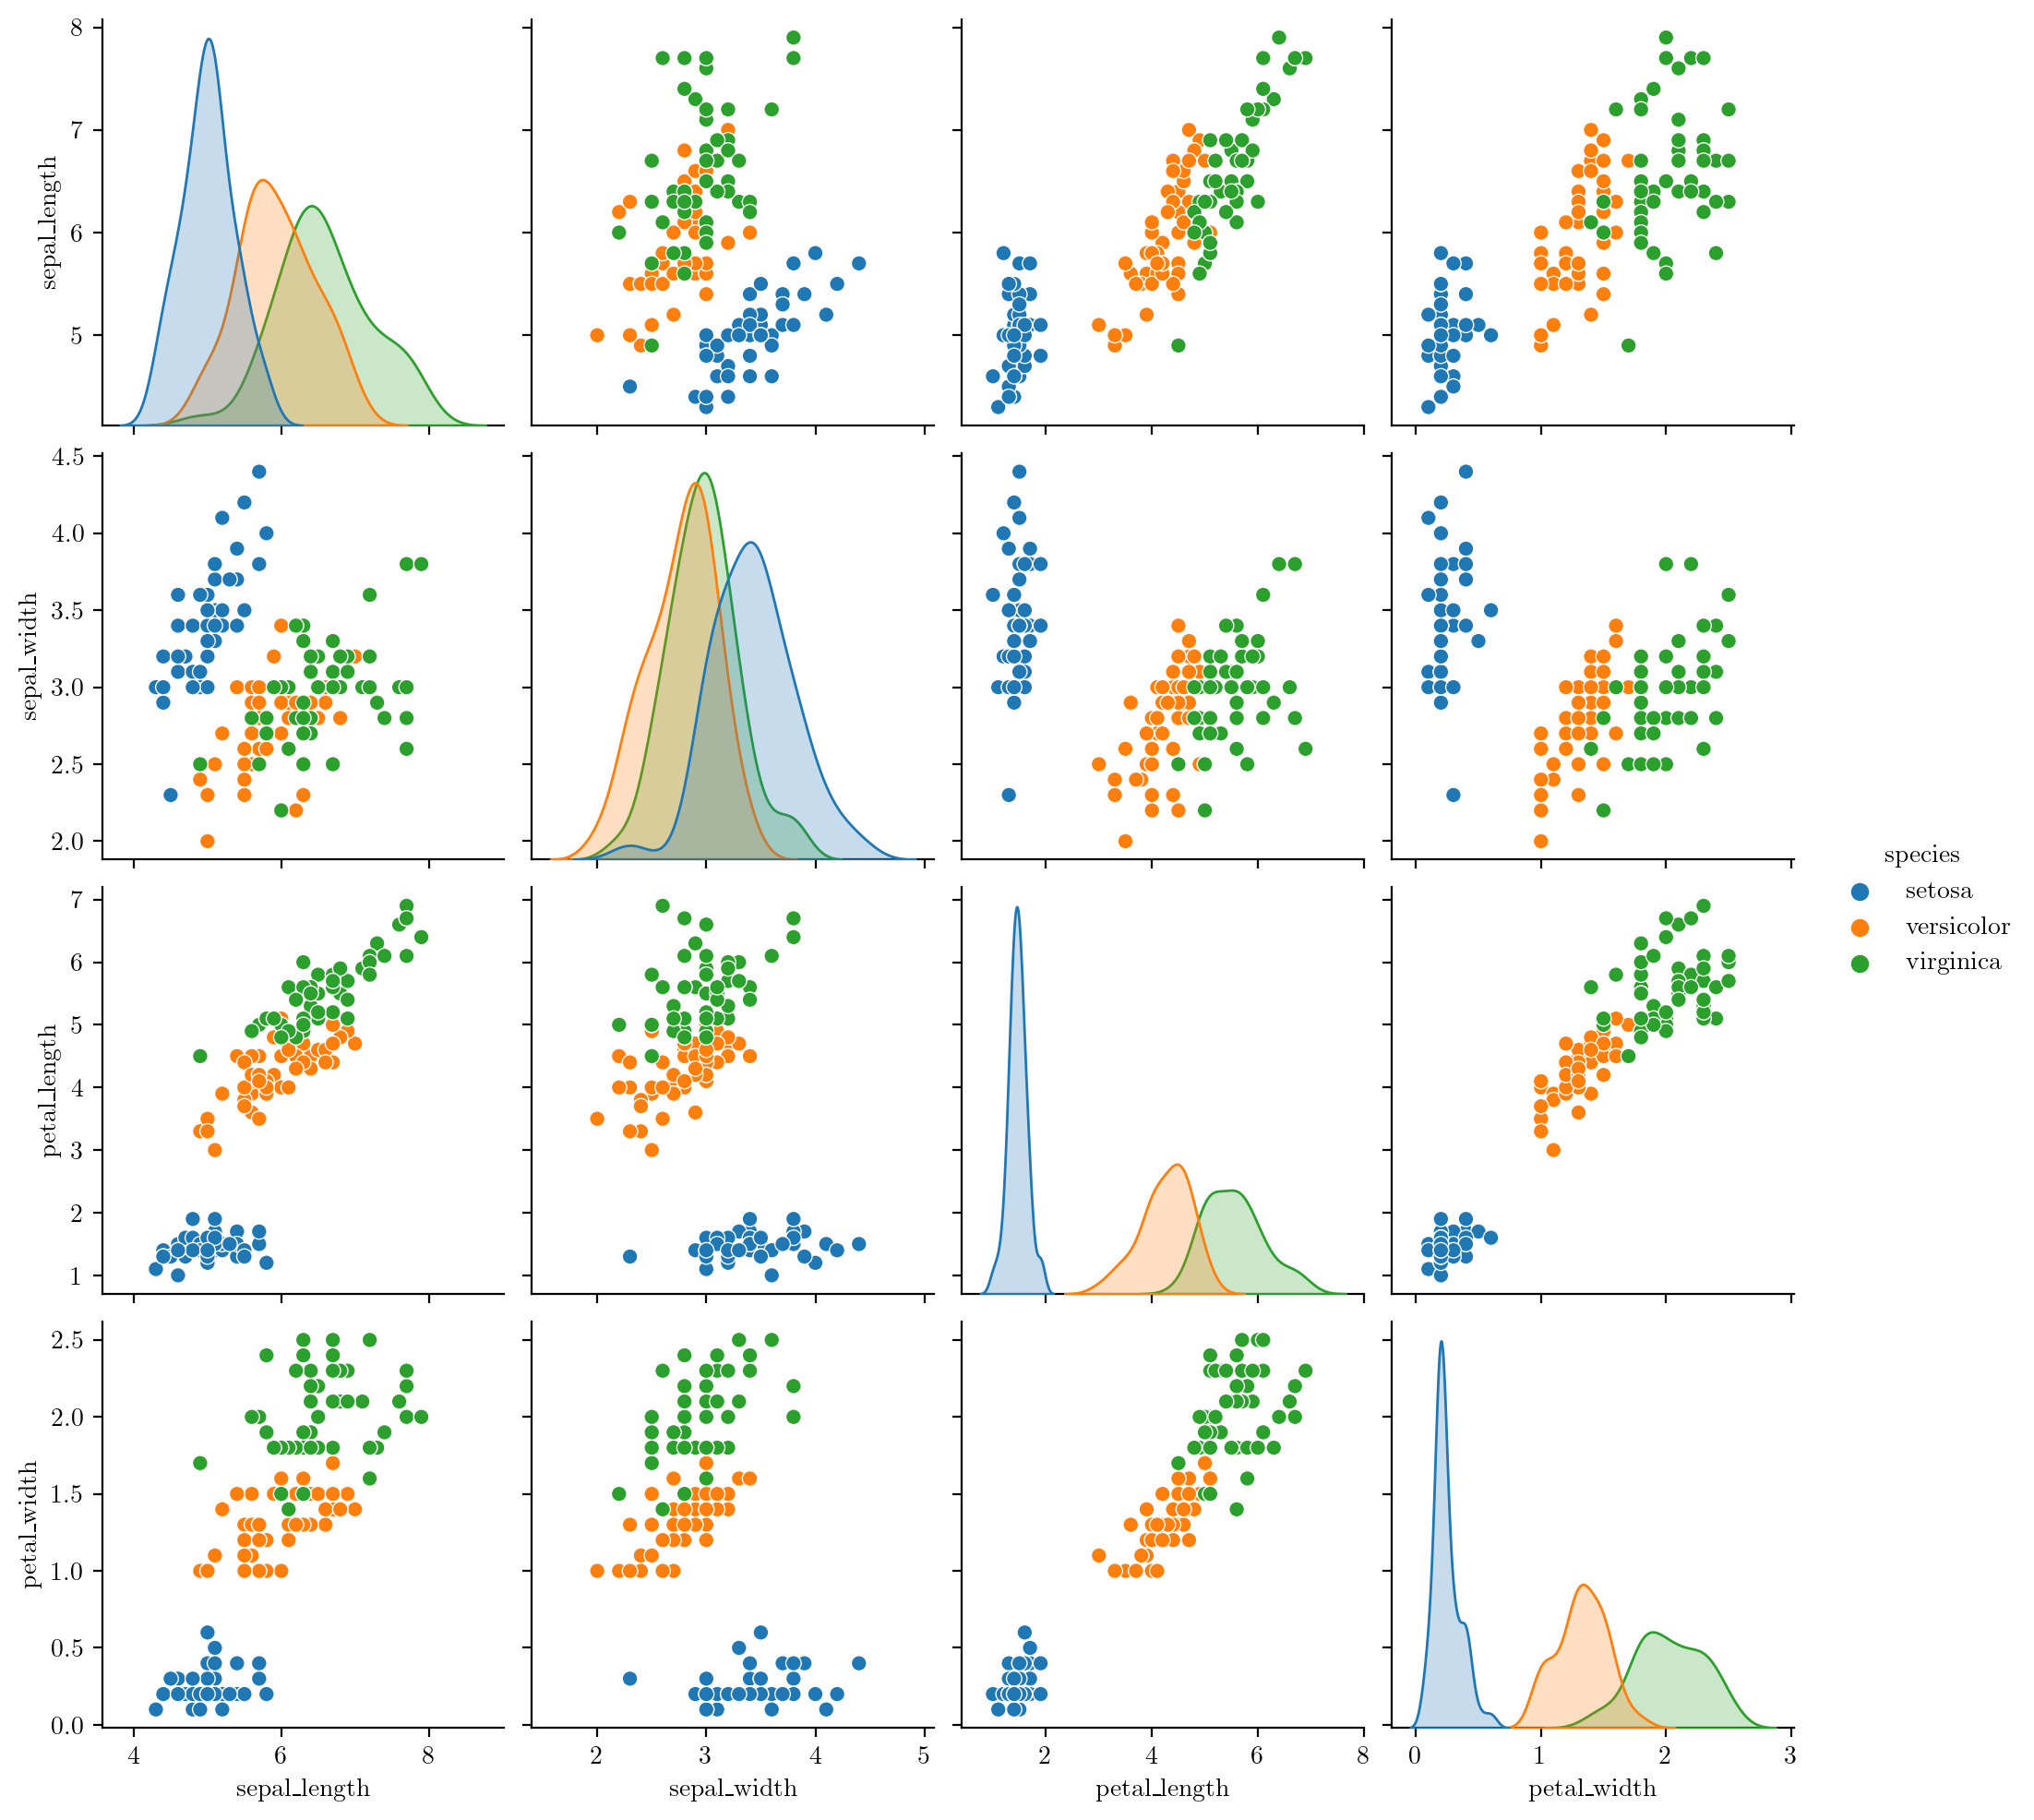

In [4]:
# Pairplot
sns.pairplot(iris, hue="species")

In [5]:
# Divide dataset into X and y
X, y = iris.iloc[:, :-1], iris.iloc[:, -1]
rf = RandomForestClassifier(n_estimators=10,random_state=0, criterion='entropy', bootstrap=True)
rf.fit(X, y)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [6]:
# Visualize each tree in the Random Forest
for i, tree in enumerate(rf.estimators_):
    # Create DOT data for the i-th tree
    dot_data = export_graphviz(tree, out_file=None, 
                               feature_names=iris.columns[:-1],  
                               class_names=iris.species.unique(),
                               filled=True, rounded=True,
                               special_characters=True,
                               impurity=True,
                               node_ids=True)
    
    # Use Graphviz to render the DOT data into a graph
    graph = graphviz.Source(dot_data)
    
    # Save or display the graph (change the format as needed)
    graph.render(filename=f'../figures/ensemble/feature-imp-{i}', format='pdf', cleanup=True)
    graph.render(filename=f'../figures/ensemble/feature-imp-{i}', format='png', cleanup=True)

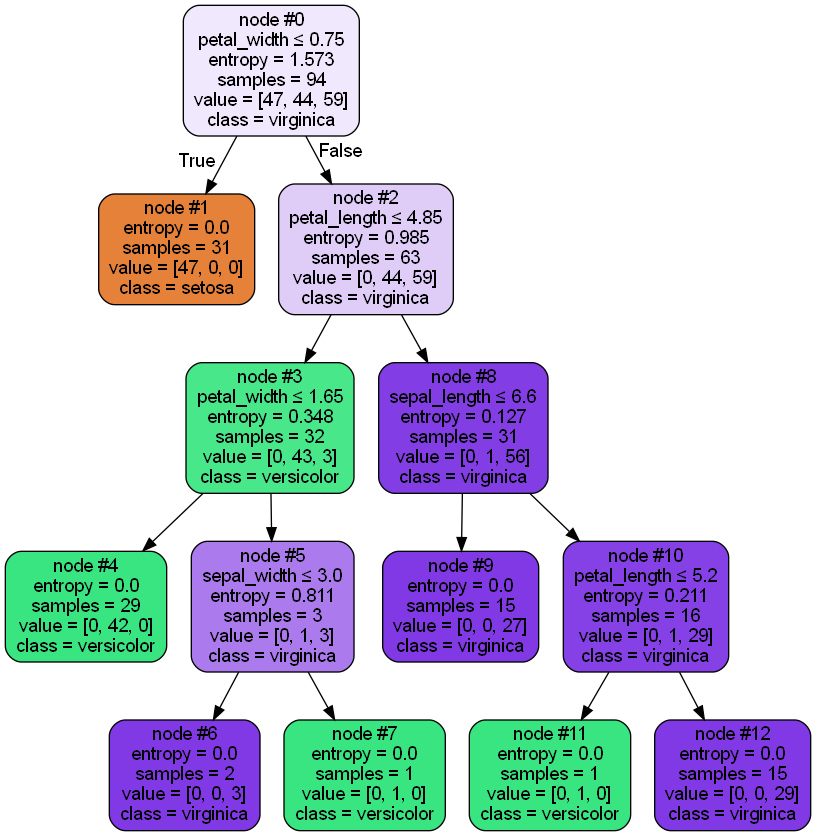

In [7]:
# Visualize the tree
Image(filename='../figures/ensemble/feature-imp-0.png')

- $t$ = node
- $N_t$ = number of observations at node $t$
- $N_{t_L}$ = number of observations in the left child node of node $t$
- $N_{t_R}$ = number of observations in the right child node of node $t$
- $p(t)=N_t/N$ = proportion of observations in node $t$
- $X_j$ = feature $j$
- $j_t$ = feature used at node $t$ for splitting
- $i(t)$ = impurity at node $t$ (impurity = entropy in this case)
- $M$ = number of trees in the forest

### For a particular node:
- Information gain at node $t$ = Impurity reduction at node $t$ = entropy(parent) - weighted entropy(children)
\begin{equation*}
  = \Delta i(t) = i(t) - \frac{N_{t_L}}{N_t} i(t_L) - \frac{N_{t_r}}{N_t} i(t_R)
\end{equation*}


### For a tree:
Importance of feature $X_j$ is given by:
\begin{equation*}
  \text{Imp}(X_j) = \sum_{t \in \varphi_{m}} 1(j_t = j) \Big[ p(t) \Delta i(t) \Big]
\end{equation*}

### For a forest:
Importance of feature $X_j$ for an ensemble of $M$ trees $\varphi_{m}$ is:

\begin{equation*}
  \text{Imp}(X_j) = \frac{1}{M} \sum_{m=1}^M \sum_{t \in \varphi_{m}} 1(j_t = j) \Big[ p(t) \Delta i(t) \Big]
\end{equation*}

In [8]:
# take one tree 
tree = rf.estimators_[0].tree_

# Creating a mapping of feature names to the feature indices
mapping = {-2: 'Leaf', 0: 'sepal_length', 1: 'sepal_width', 2: 'petal_length', 3: 'petal_width'}

# print the node number along with the corresponding feature name
for node in range(tree.node_count):
    print(f'Node {node}: {mapping[tree.feature[node]]}')

Node 0: petal_width
Node 1: Leaf
Node 2: petal_length
Node 3: petal_width
Node 4: Leaf
Node 5: sepal_width
Node 6: Leaf
Node 7: Leaf
Node 8: sepal_length
Node 9: Leaf
Node 10: petal_length
Node 11: Leaf
Node 12: Leaf


In [9]:
def print_child_id(tree, node):
    '''
    Prints the child node ids of a given node.
    tree: tree object
    node: int
    '''

    # check if leaf
    l, r = tree.children_left[node], tree.children_right[node]
    if l == -1 and r == -1:
        return None, None
    return tree.children_left[node], tree.children_right[node]

print_child_id(tree, 0)

(1, 2)

In [10]:
def all_data(tree, node):
    '''
    Returns all the data required to calculate the information gain.
    '''

    # get the child nodes
    left, right = print_child_id(tree, node)

    # check if leaf, then return None
    if left is None:
        return None
    
    # get the data
    entropy_node = tree.impurity[node]
    entropy_left = tree.impurity[left]
    entropy_right = tree.impurity[right]

    # N = total number of samples considered during bagging, therefore, it is equal to the number of samples at the root node
    N = tree.n_node_samples[0]

    # n_l = number of samples at the left child node
    n_l = tree.n_node_samples[left]

    # n_r = number of samples at the right child node
    n_r = tree.n_node_samples[right]

    # n_t = total number of samples at the node
    n_t = n_l + n_r

    feature = mapping[tree.feature[node]]
    
    # calculate the information gain
    info_gain_t = entropy_node - (n_l/n_t * entropy_left + n_r/n_t * entropy_right)
    
    return info_gain_t, N, n_l, n_r, n_t, feature

In [11]:
# Calculate the importance of each features using the information gain for a tree

scores = {}
for node in range(tree.node_count):
    # Add the information gain of the node to the dictionary if it is not a leaf node
    try:
        ig, N, n_l, n_r, n_t, feature = all_data(tree, node)
        p_t = n_t / N
        scores[feature] = scores.get(feature, 0) + p_t * ig

    # Skip if it is a leaf node
    except:
        continue

ser = pd.Series(scores) 
info_gain_tree = ser/ser.sum()
info_gain_tree.sort_values(ascending=False)

petal_width     0.639307
petal_length    0.340335
sepal_width     0.016459
sepal_length    0.003899
dtype: float64

In [12]:
# Feature importance using sklearn for a tree
sklearn_imp = tree.compute_feature_importances()
pd.Series(sklearn_imp, index=iris.columns[:-1]).sort_values(ascending=False)

petal_width     0.624251
petal_length    0.358024
sepal_width     0.013752
sepal_length    0.003973
dtype: float64

In [13]:
# Feature importance using sklearn for the forest
sklearn_imp_forest = np.array([x.tree_.compute_feature_importances() for x in rf.estimators_]).mean(axis=0)
pd.Series(sklearn_imp_forest, index=iris.columns[:-1]).sort_values(ascending=False)

petal_width     0.544270
petal_length    0.323122
sepal_length    0.098647
sepal_width     0.033960
dtype: float64

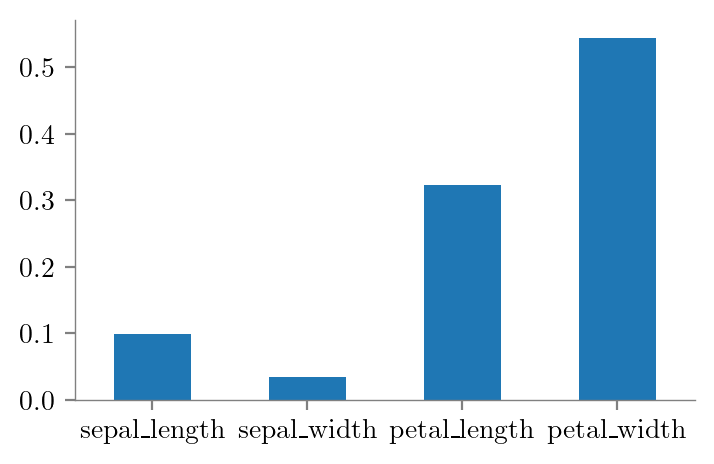

In [15]:
ser = pd.Series(sklearn_imp_forest, index=iris.columns[:-1])
ser.plot(kind='bar', rot=0)
format_axes(plt.gca())
plt.savefig('../figures/ensemble/feature-imp-forest.pdf', bbox_inches='tight')

### Aside:
`tree.tree_.feature` returns the feature used at each node to divide the node into two child nodes with the below given mapping. The sequence of the features is the same as the column sequence of the input data.

- -2: leaf node
- 0: sepal_length
- 1: sepal_width
- 2: petal_length
- 3: petal_width

`tree.tree_.children_left[node]` returns the node number of the left child of the node

`tree.tree_.children_right[node]` returns the node number of the right child of the node

if there is no left or right child, it returns -1

### Bootstrap code:
in the random_forest.fit() function

![bootstrap_code](../diagrams/ensemble/bootstrap_code.png)